In [41]:
import pandas as pd # pannel datasets
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from calendar import monthrange, month_name
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pylab
import scipy.stats as stats

In [3]:
# load the data using pandas
df = pd.read_excel('QualidadeARO3.xlsx', sheet_name='Sheet1', engine="openpyxl")

In [4]:
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Antas-Espinho      8784 non-null   float64
 1   Entrecampos        8784 non-null   float64
 2   Estarreja          8784 non-null   float64
 3   Ihavo              8784 non-null   float64
 4   Laranjeiro-Almada  8784 non-null   float64
 5   Mem-Martins        8784 non-null   float64
 6   Paio-Pires         8784 non-null   float64
 7   Restelo            8784 non-null   float64
 8   Sobreiras-Porto    8784 non-null   float64
 9   VNTelha-Maia       8784 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 686.4 KB


In [5]:
# Calculate month range borders (we need that later)
year = 2000
days = 0
ranges = []
for i in range(12):
    start = days
    days += monthrange(year, i+1)[1] * 24
    end = days
    ranges.append((start,end))
month_cuts = [x[1] for x in ranges]

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
('Estarreja', 37.13734472310293, 26.04513225589056)
('Antas-Espinho', 41.91886149009665, 21.365148008704868)
('Sobreiras-Porto', 50.92896174863388, 28.615851897398933)
('Entrecampos', 52.69962431693989, 27.363527127874548)
('Paio-Pires', 52.986190699772756, 25.68408034059013)
('Restelo', 53.59471222354255, 24.64105431106354)
('Laranjeiro-Almada', 56.73644042274474, 26.92704391936502)
('Ihavo', 57.31659836065574, 27.259929287552925)
('Mem-Martins', 66.42042349726776, 24.034454452089598)


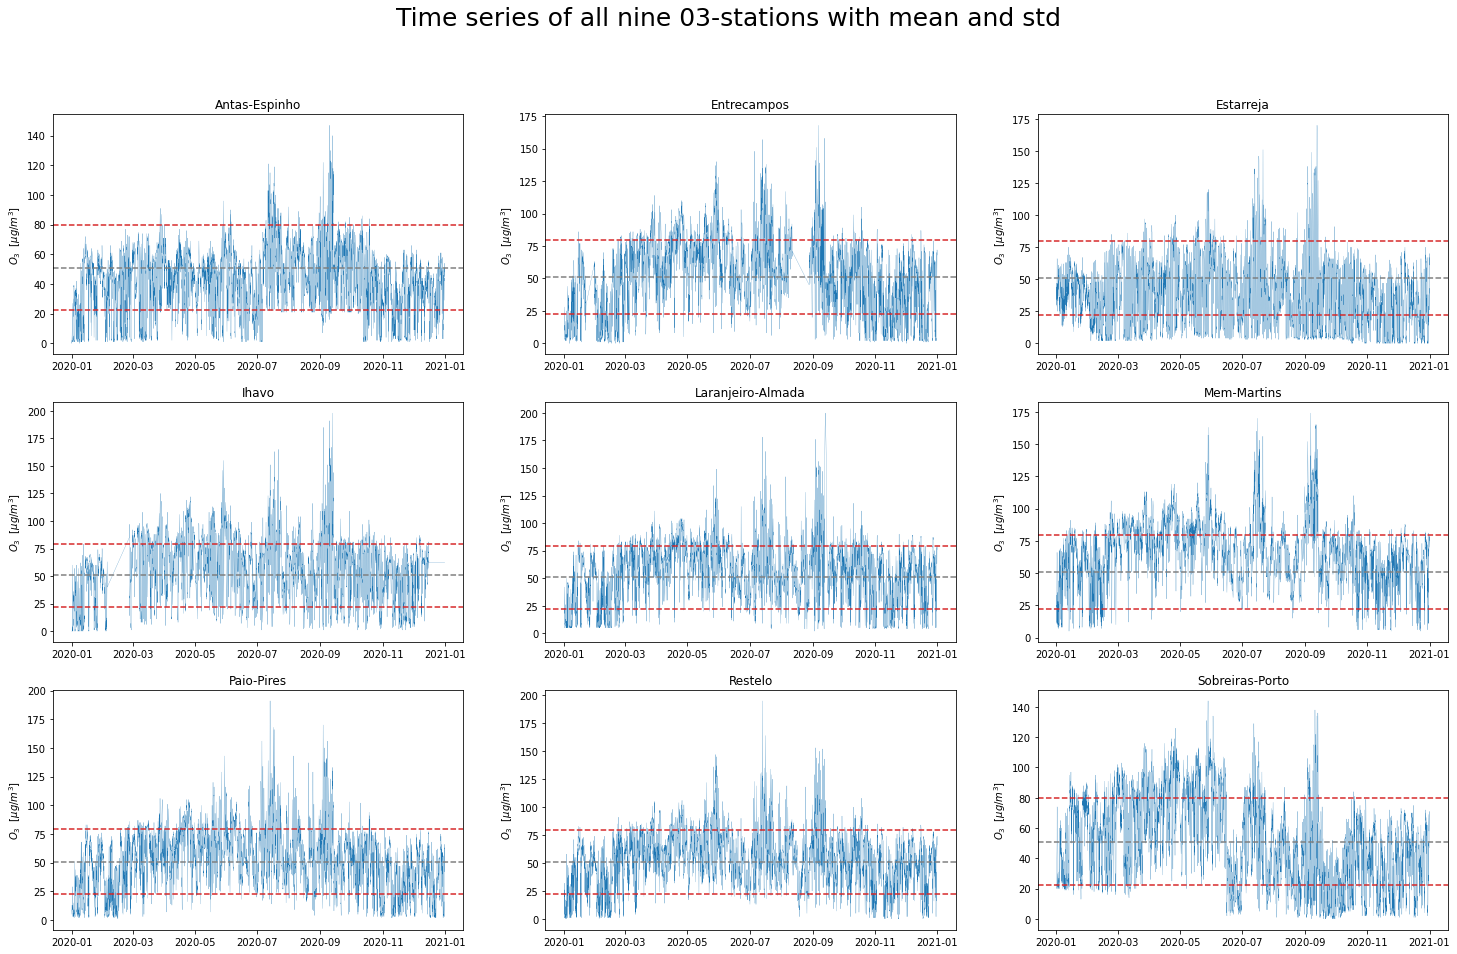

In [6]:
# Divide the series into subseries
names = df.columns
series = [df[name] for name in names]

# Time span
dates = pd.date_range("2020-01-01", periods=len(df), freq="H")

# Time plots of all nine series for an initial look
n1, m2 = 3, 3
amount_series = range(n1*m2)
y_label = '$O_3$  $[\mu g/m^3]$'

data = []
for i in amount_series:
    mean, std = series[i].mean(), series[i].std()
    data.append((names[i], mean, std))
data.sort(key=lambda x: x[1])

fig1, axs1 = plt.subplots(n1, m2, figsize=(25,15))
fig1.suptitle(f"Time series of all nine 03-stations with mean and std", fontsize=25)

for i,_ in enumerate(data):
    x, y = int(i/n1), i%n1
    print(x,y)
    axs1[x, y].plot_date(dates, series[i], fmt="-", linewidth=0.2)#colors[x])
    axs1[x, y].set_ylabel(y_label)
    axs1[x, y].set_title(names[i])
    axs1[x, y].axhline(y=mean, color='tab:gray', linestyle='--')
    axs1[x, y].axhline(y=mean+std, color='tab:red', linestyle='--')
    axs1[x, y].axhline(y=mean-std, color='tab:red', linestyle='--')

print(*data, sep="\n")

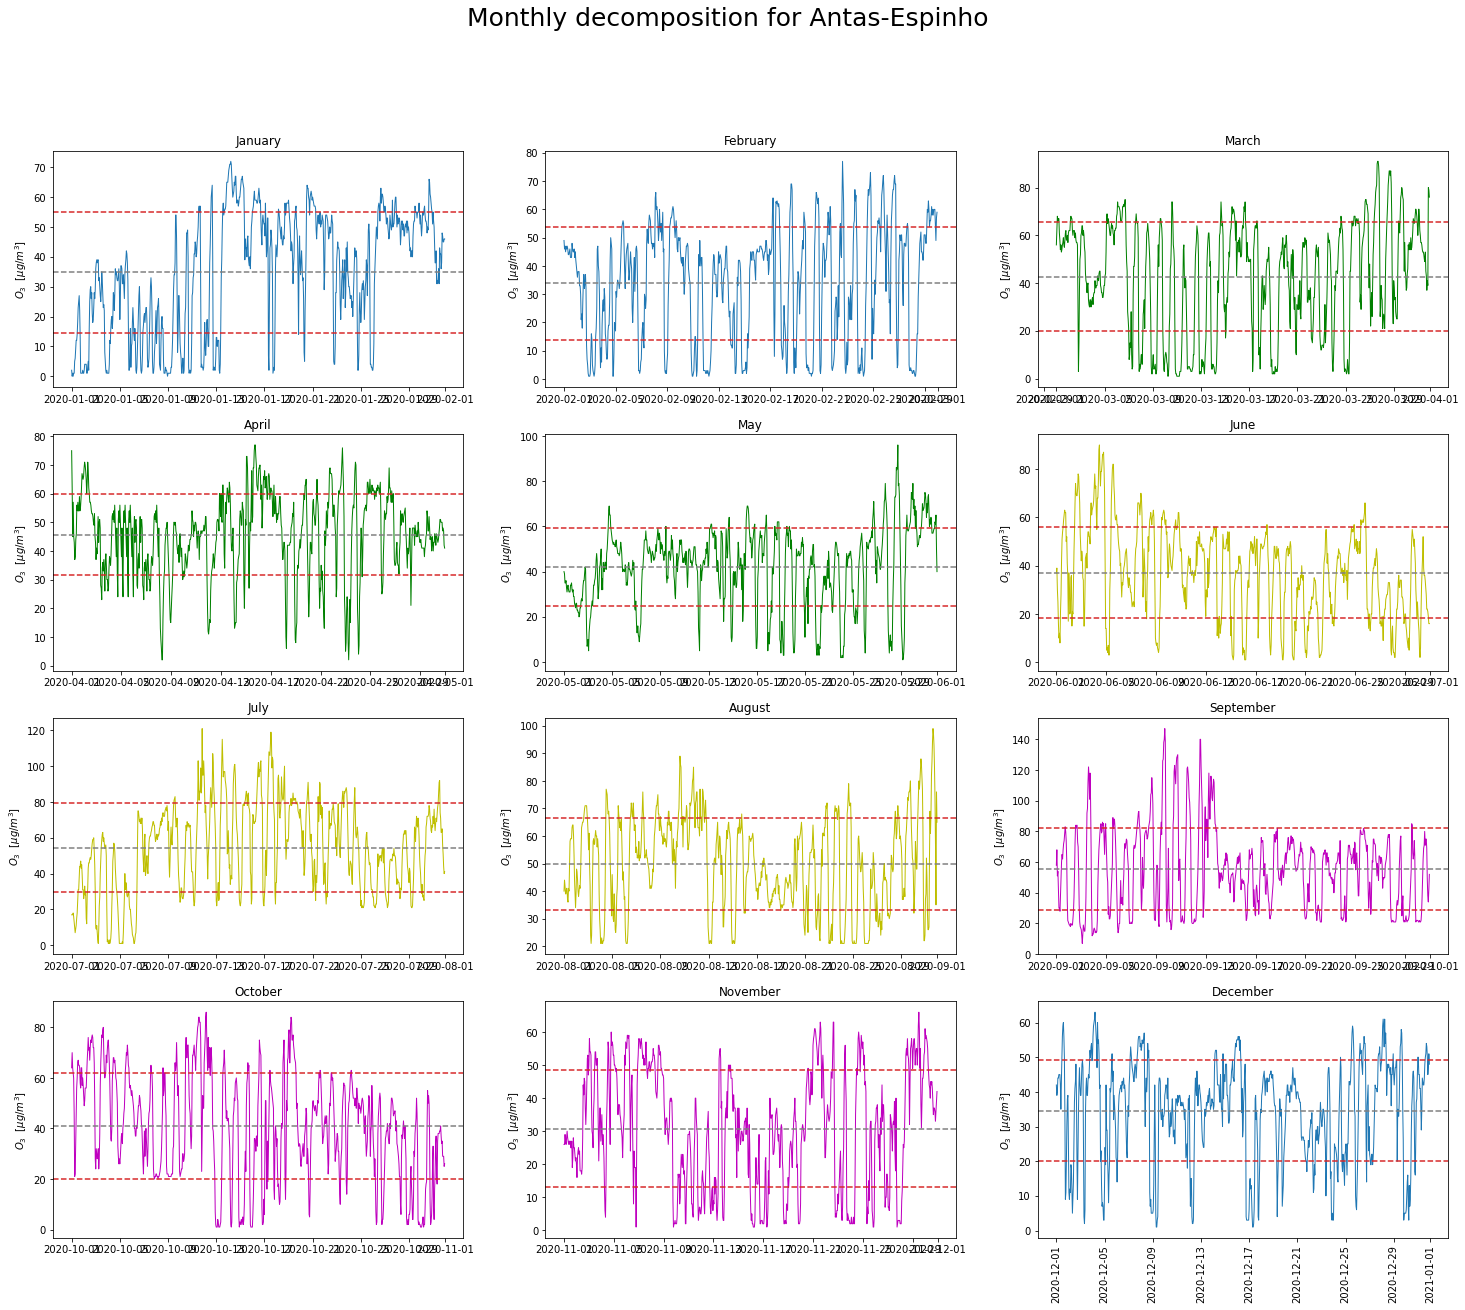

In [7]:
# Analyzing month by month
colors = ["-", "-", "g-","g-","g-", "y-","y-","y-", "m-","m-","m-", "-",]
number = 0
current_series = series[number]
n2, m2, months = 4, 3, 12
days = 0
fig2, axs2 = plt.subplots(n2, m2, figsize=(25,20))
fig2.suptitle(f"Monthly decomposition for {names[number]}", fontsize=25)
data = []
for i, (start, end) in enumerate(ranges):
    x, y = int(i/m2), i%m2
    month_series = current_series[start:end]
    month_dates = dates[start:end]
    mean, std = month_series.mean(), month_series.std()
    axs2[x, y].plot_date(month_dates, month_series, fmt=colors[i], linewidth=1)
    axs2[x, y].set_ylabel(y_label)
    axs2[x, y].set_title(datetime.date(2000, i+1, 1).strftime('%B'))
    axs2[x, y].axhline(y=mean, color='tab:gray', linestyle='--')
    axs2[x, y].axhline(y=mean + std, color='tab:red', linestyle='--')
    axs2[x, y].axhline(y=mean - std, color='tab:red', linestyle='--')
    plt.xticks(rotation=90)

In [8]:
#Dickey fuller test

for i in range(len(names)):
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(series[i].values, regression="n")
    print(names[i],'test statistic:', adf, 'ADF p-values:', pval)
#print('ADF number of lags used:', usedlag)
#print('ADF number of observations:', nobs)
#print('ADF critical values:', crit_vals)
#print('ADF best information criterion:', icbest)


Antas-Espinho test statistic: -2.8756073626014444 ADF p-values: 0.0039500062141623864
Entrecampos test statistic: -2.5626217161139206 ADF p-values: 0.010057095322530294
Estarreja test statistic: -3.1516614118279986 ADF p-values: 0.0016202894111928135
Ihavo test statistic: -2.1873321648452624 ADF p-values: 0.027580546644750237
Laranjeiro-Almada test statistic: -2.8234032690155644 ADF p-values: 0.004642703726997428
Mem-Martins test statistic: -1.8446689425167955 ADF p-values: 0.06198107643230114
Paio-Pires test statistic: -2.4687909671794563 ADF p-values: 0.013094128424694242
Restelo test statistic: -2.2582698745590997 ADF p-values: 0.023012503014116118
Sobreiras-Porto test statistic: -2.6942345204833895 ADF p-values: 0.00685758141335438
VNTelha-Maia test statistic: -2.922180092958799 ADF p-values: 0.0034133000762102085


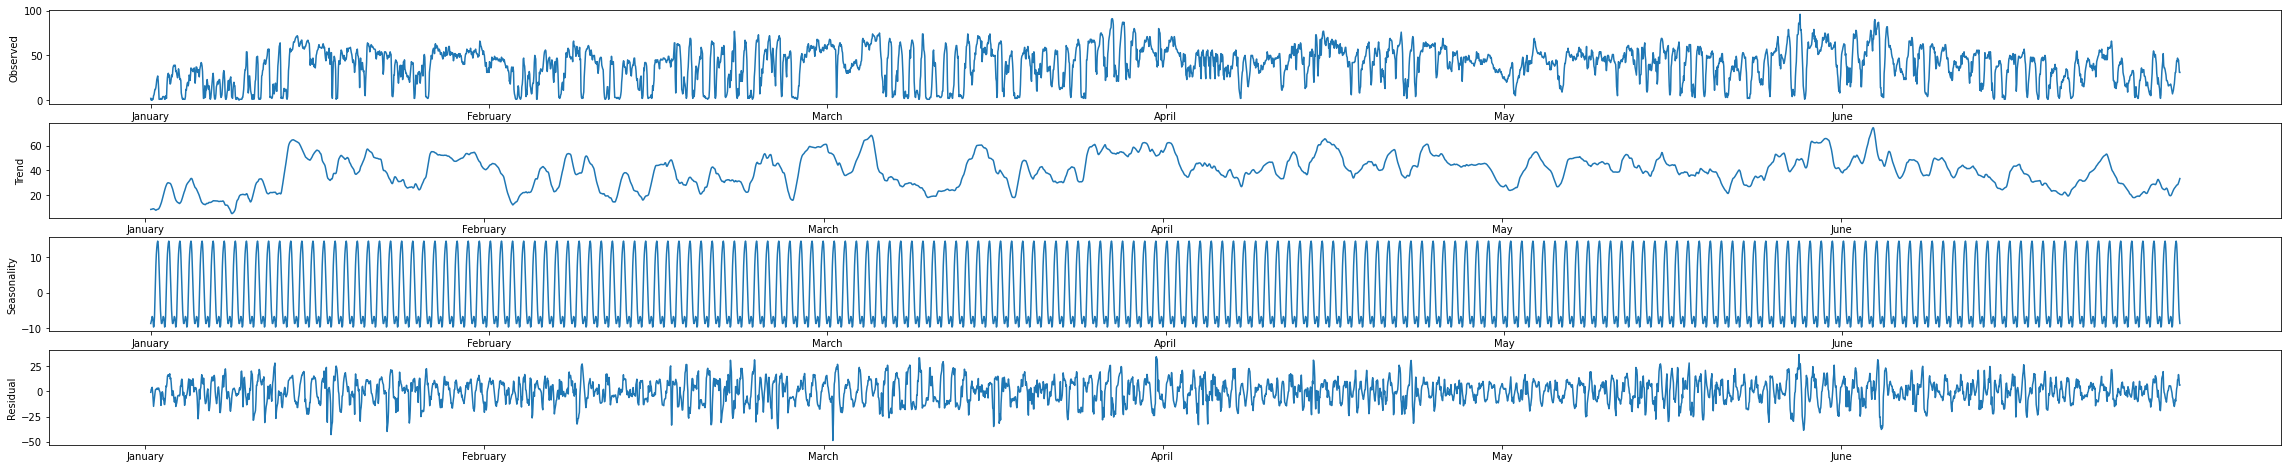

In [44]:
#Trends and seasonality
k = 2
result = seasonal_decompose(series[0], model='additive', period = 24)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(40,8))
n = int(len(current_series)/k)
current_series[:n].plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend[:n].plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal[:n].plot(ax=ax3)
ax3.set_ylabel('Seasonality')
result.resid[:n].plot(ax=ax4)
ax4.set_ylabel('Residual')
for i in range(1,5):
    eval(f"ax{i}").set_xticks([i*int(n/(12/k)) for i in range(int(12/k))], minor=False)
    eval(f"ax{i}").set_xticklabels(month_name[1:int(12/k)+1], fontdict=None, minor=False)

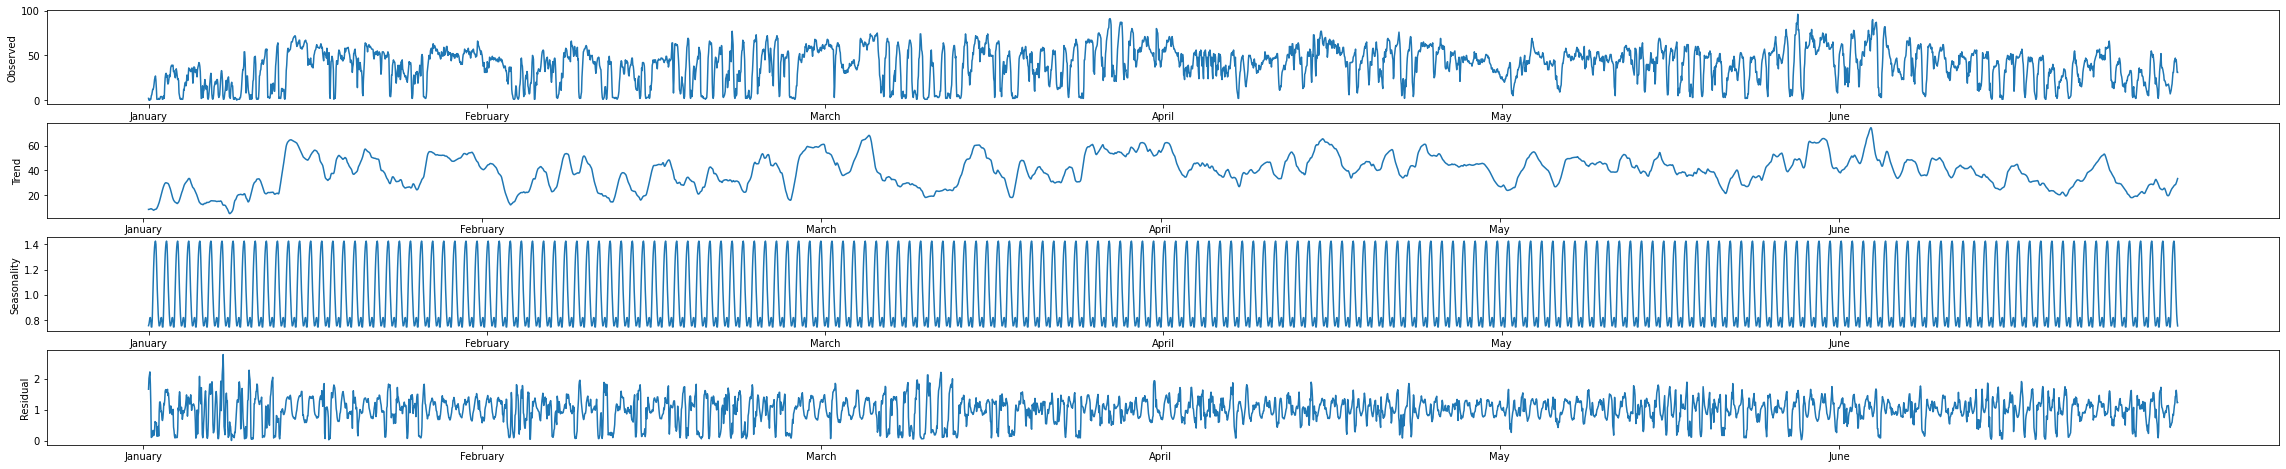

In [45]:
s = pd.Series([x+0.0001 for x in series[0]])
result = seasonal_decompose(s, model='m', period = 24)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(40,8))
n = int(len(current_series)/k)
current_series[:n].plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend[:n].plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal[:n].plot(ax=ax3)
ax3.set_ylabel('Seasonality')
result.resid[:n].plot(ax=ax4)
ax4.set_ylabel('Residual')
for i in range(1,5):
    eval(f"ax{i}").set_xticks([i*int(n/(12/k)) for i in range(int(12/k))], minor=False)
    eval(f"ax{i}").set_xticklabels(month_name[1:int(12/k)+1], fontdict=None, minor=False)

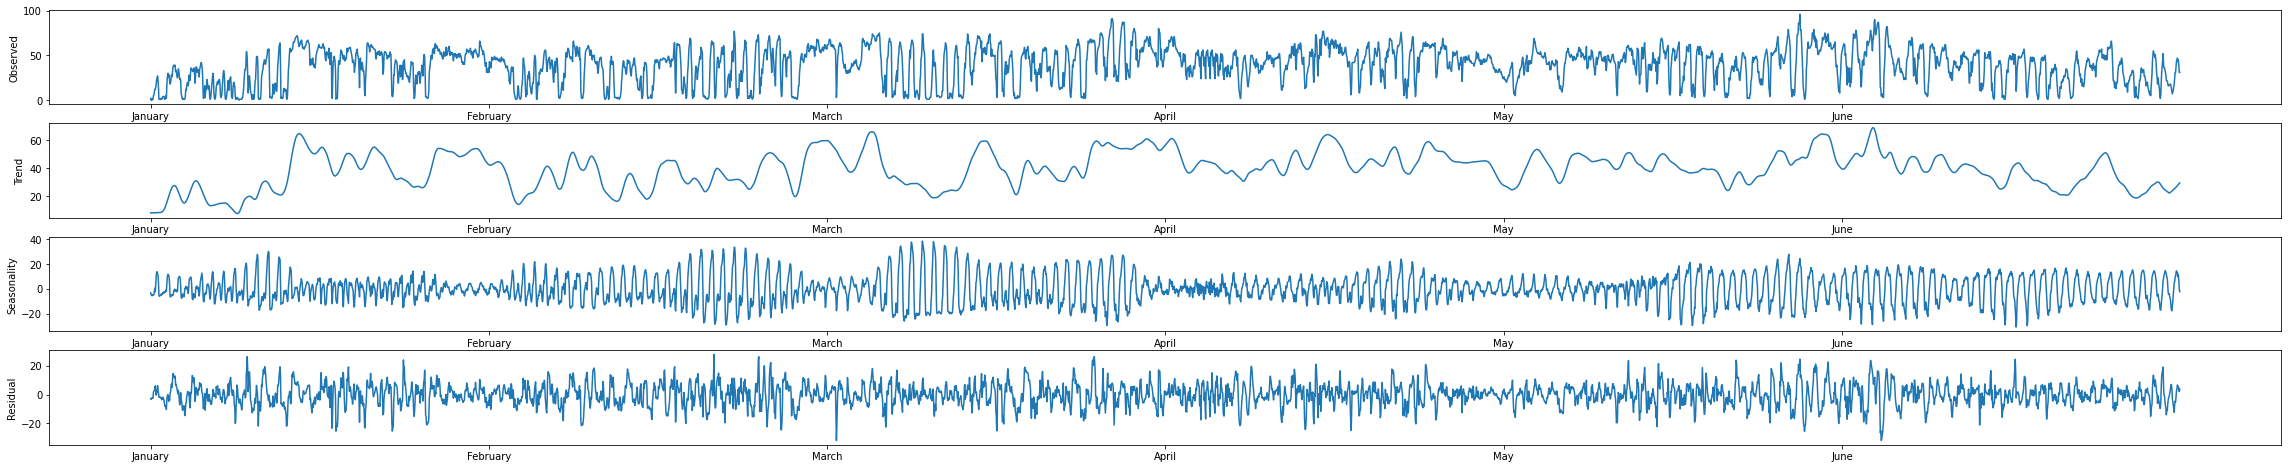

In [46]:
from statsmodels.tsa.seasonal import STL
result = STL(endog=series[0][:int(len(current_series)/k)], period=24).fit()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(40,8))
n = int(len(current_series)/k)
current_series[:n].plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend[:n].plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal[:n].plot(ax=ax3)
ax3.set_ylabel('Seasonality')
result.resid[:n].plot(ax=ax4)
ax4.set_ylabel('Residual')
for i in range(1,5):
    eval(f"ax{i}").set_xticks([i*int(n/(12/k)) for i in range(int(12/k))], minor=False)
    eval(f"ax{i}").set_xticklabels(month_name[1:int(12/k)+1], fontdict=None, minor=False)

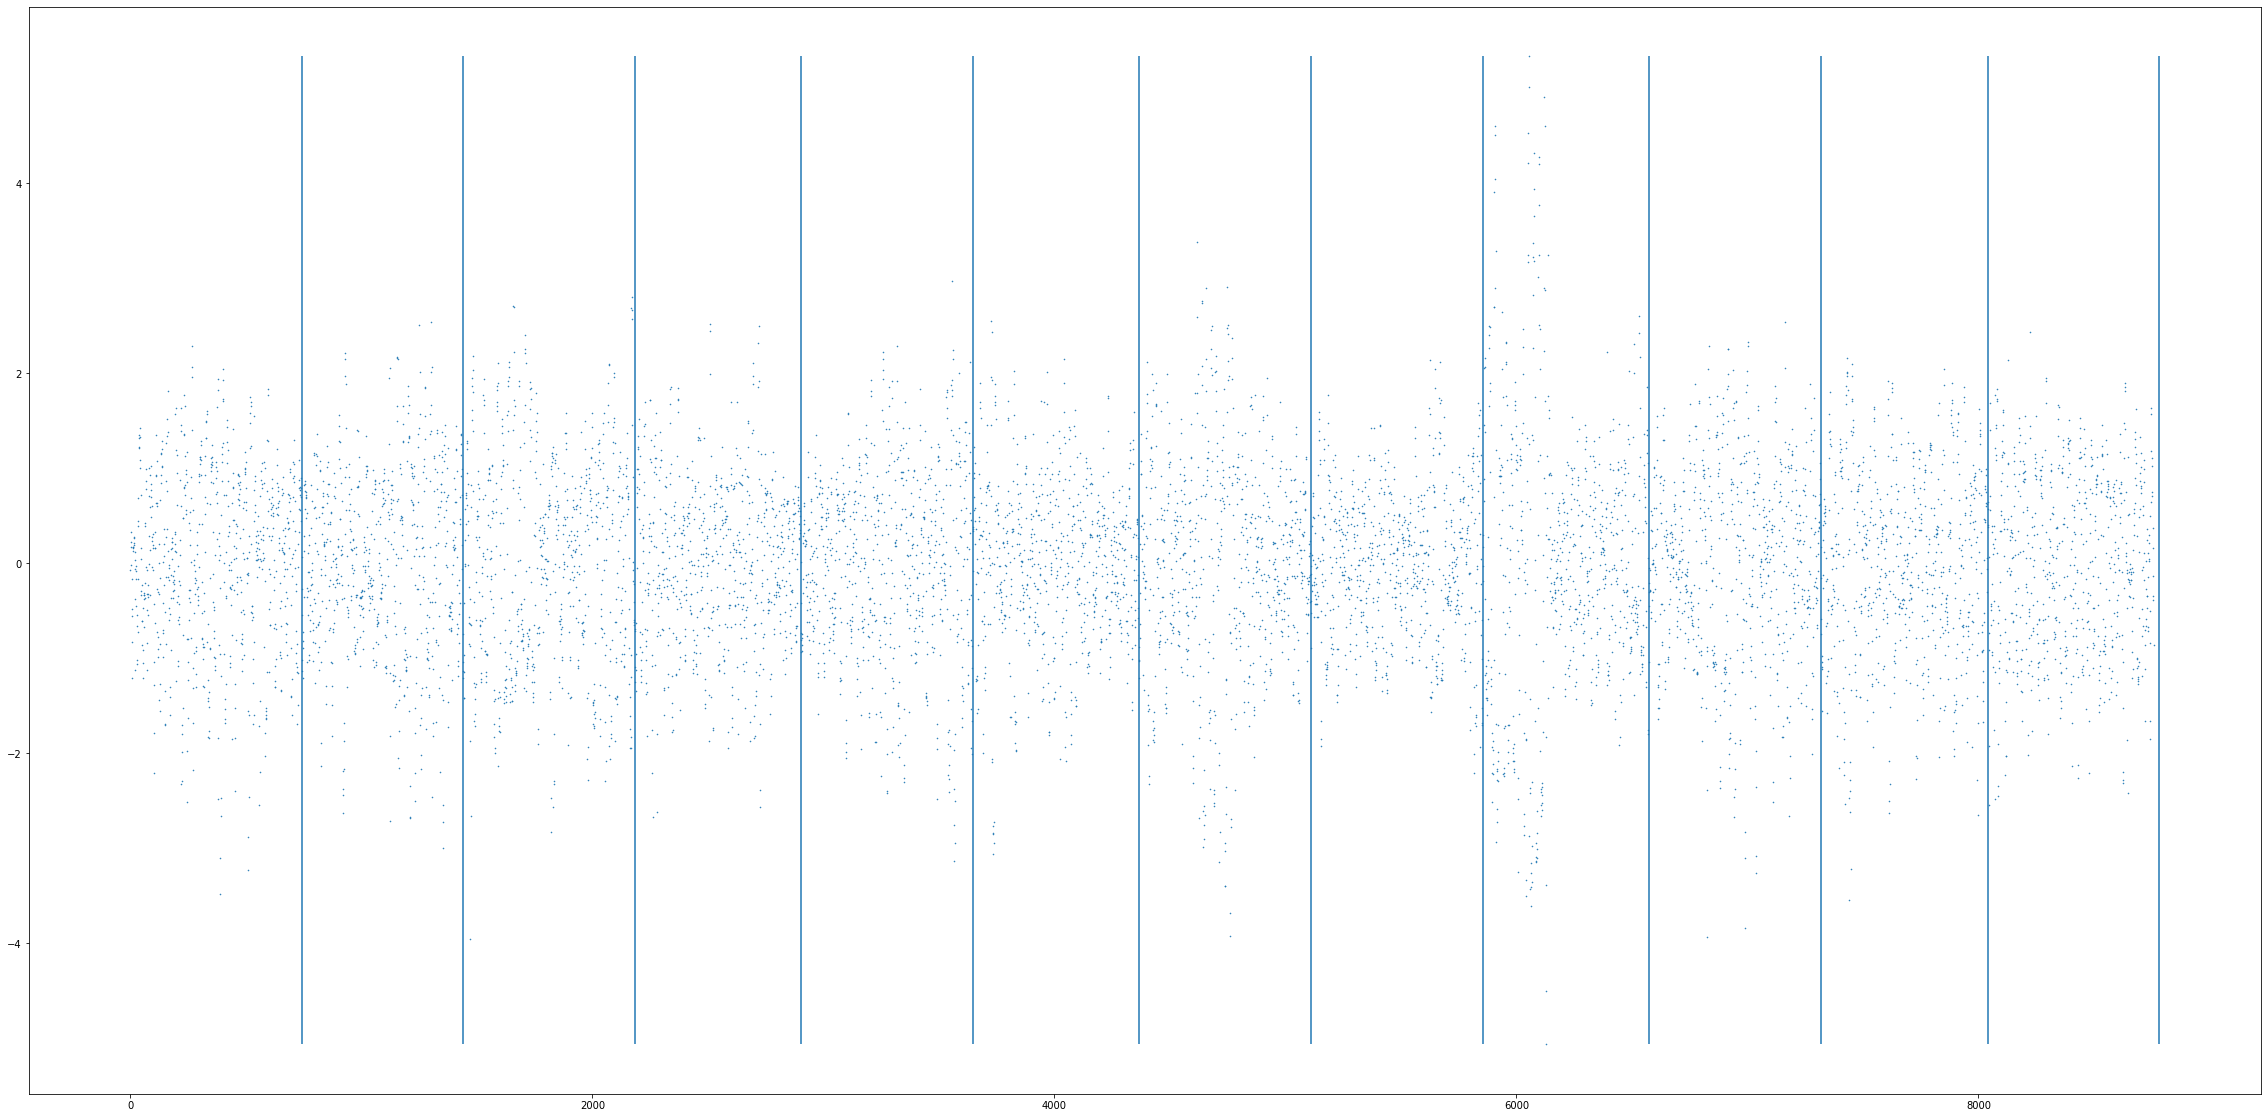

In [9]:
# (Standardized) Residual plot
residuals = result.resid.dropna()
mean, std = residuals.mean(), residuals.std()
standardized_residuals = residuals.apply(lambda x: (x-mean)/std)
fig, axs = plt.subplots(1, figsize=(40,20))
axs.scatter(x=range(len(standardized_residuals)), y=standardized_residuals, s=0.3)
axs.vlines(x=month_cuts, ymin=min(standardized_residuals), ymax=max(standardized_residuals))
#axs.text(500,200,"test")

Reject, noise follows N-distribution


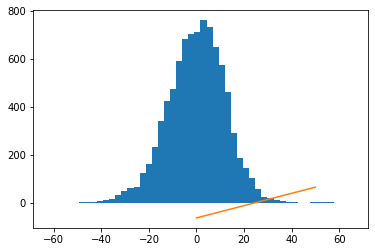

In [10]:
# Do normal test on the noise of the decomposed time series
n, bins, patches = plt.hist(residuals, 50)
plt.plot(bins)

# Normal test
alpha = 1e-3
k2, p = stats.normaltest(residuals)
result = "Reject, noise follows N-distribution" if p<alpha else "Reject, noise does not follow N-distribution"
print(result)

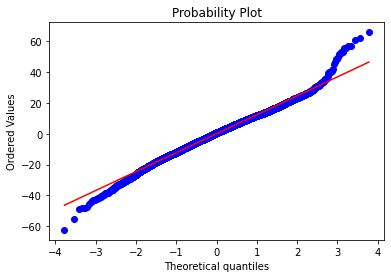

In [12]:
# QQ Plot
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

/Users/marcelbraasch/Desktop/TimeSeriesProject/venv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


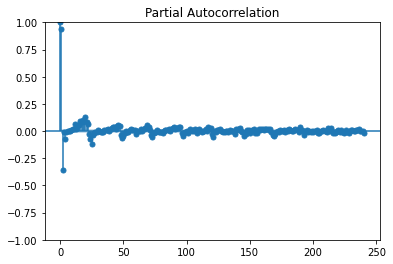

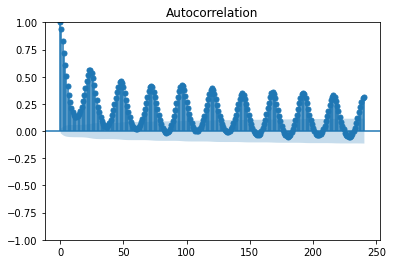

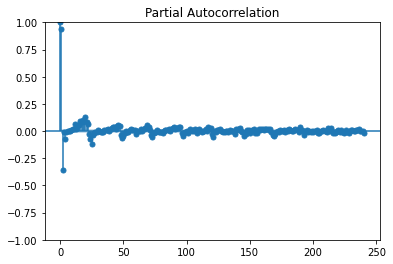

In [14]:
#ACF and PACF plots
lags = 24 * 10
plot_acf(current_series, lags=lags)
plot_pacf(current_series, lags=lags)

In [14]:
#Splitting data for evaluation
training_portion = 0.9
split = int(training_portion*len(current_series))
train, test = current_series[:split], current_series[split:]

In [29]:
# Hyperparamter grid Search
# m = (24,)
# p = d = q = range(0,3)
# pdqs = list(itertools.product(p,d,q))
# PDQs = pdqs

order_parameter = (1,0,1)
seasonal_parameter = (2,0,1)
m = (24,)
model = SARIMAX(current_series, order=order_parameter, seasonal_order=seasonal_parameter+m).fit()
print(model.summary())

# best_aic = float("inf")
# best_config = None
# best_model = None
# for order_parameter in tqdm(pdqs):
#     for seasonal_parameter in tqdm(PDQs):
#         model = SARIMAX(current_series, order=order_parameter, seasonal_order=seasonal_parameter+m).fit()
#         aic = model.aic
#         if aic < best_aic:
#             best_aic = aic
#             best_config = [order_parameter, seasonal_parameter]
#             best_model = model
# print(f"Best config is {best_config} with AIC of {best_aic}. Model saved.")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46594D+00    |proj g|=  2.03431D-01


 This problem is unconstrained.



At iterate    5    f=  3.34283D+00    |proj g|=  1.56224D-02

At iterate   10    f=  3.33578D+00    |proj g|=  8.32854D-03

At iterate   15    f=  3.31730D+00    |proj g|=  7.04882D-02

At iterate   20    f=  3.31226D+00    |proj g|=  6.71225D-03

At iterate   25    f=  3.31183D+00    |proj g|=  1.67989D-03

At iterate   30    f=  3.31170D+00    |proj g|=  1.06935D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     41      1     0     0   2.118D-06   3.312D+00
  F =   3.3116992742323950     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Result

In [25]:
# Get the predictions and residuals
predictions = model.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions
#print(predictions)

- What is the moving average doing?
- What is cutting and tailing off?
-


Text(0, 0.5, 'Error')

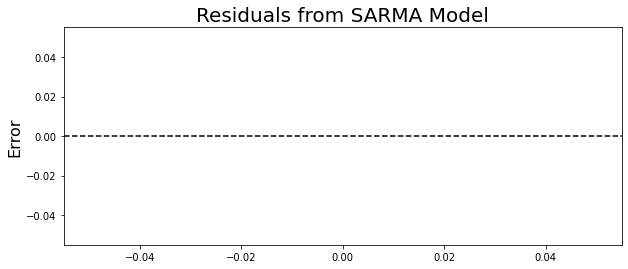

In [26]:
#Plotting residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

ValueError: x and y must have same first dimension, but have shapes (1379,) and (0,)

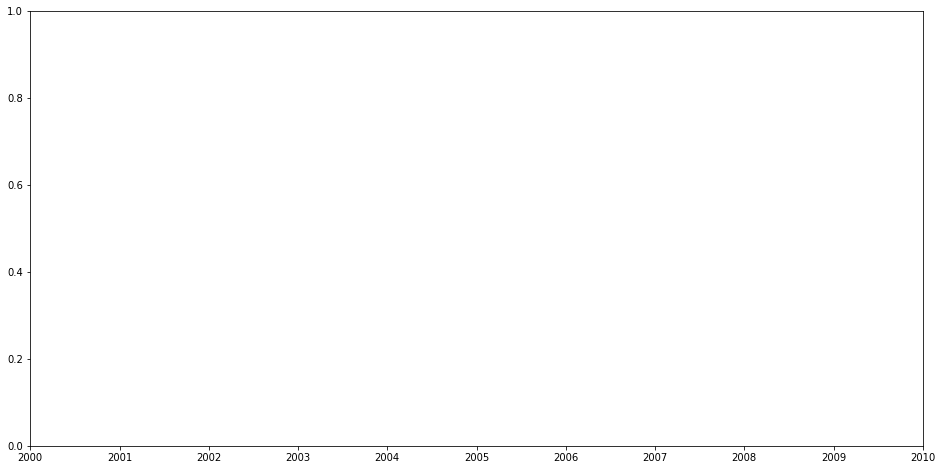

In [27]:
#Plotting
plt.figure(figsize=(16,8))

plt.plot(dates[split-500::],series[split-500::])
plt.plot(dates[split::],predictions)

plt.legend(('Data', 'Predictions'), fontsize=11)



https://neptune.ai/blog/select-model-for-time-series-prediction-task
You can detect non-stationarity using the Dickey-Fuller Test and you can remove non-stationarity using differencing.

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/